#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
hak=1 # moment of area vs moment of inertia; has proportionality coefficient

In [11]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=hak*np.diag(diag_Irho)

In [12]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [13]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [14]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [15]:
vessel_inertia

60751987031.24999

In [16]:
def Jv(X,Y,Z,i):
    
    l=[]
    for j in range(1,len(X)):
        l.append(math.sqrt((X[j]-X[j-1])**2+(Y[j]-Y[j-1])**2+(Z[j]-Z[j-1])**2))
    
    
    
    def Jv0(i, k, l):

        if k<i:
            tmp1=np.dot(l[k:i],[((X[p]-X[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp1+=0.5*l[len(X)-2]*(X[len(X)-1]-X[len(X)-1-1])/l[len(X)-2]

            tmp2=np.dot(l[k:i],[((Y[p]-Y[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp2+=0.5*l[len(Y)-2]*(Y[len(Y)-1]-Y[len(Y)-1-1])/l[len(Y)-2]

            tmp3=np.dot(l[k:i],[((Z[p]-Z[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp3+=0.5*l[len(Z)-2]*(Z[len(Z)-1]-Z[len(Z)-1-1])/l[len(Z)-2]
            
            return np.array([tmp1, tmp2, tmp3]).T
        elif i==k:
            return np.array([0.5*l[i]*(X[i]-X[i-1])/l[i],0.5*l[i]*(Y[i]-Y[i-1])/l[i],0.5*l[i]*(Z[i]-Z[i-1])/l[i]]).T
        else:
            return np.array([0, 0, 0]).T 
        
    ans=np.array([Jv0(i, k,  l) for k in range(len(X))])    
                
    return ans
           

In [17]:
def inert(M, m, X):

    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [18]:
# def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
#     V_rho=np.zeros(Irho_.shape)
#     np.fill_diagonal(V_rho, vessel_inertia)
#     cum_m=0
#     cum_i=0
#     fin_123=[]
#     for i in range(node_N-1,-1,-1):
#         cum_m+=Ws[i]*cum_d_inv[i]**2
#         cum_i+=Irho_
#         fin_123.append(V_rho+cum_m + cum_i)
#     return np.array(fin_123[::-1])

In [19]:
lll = [100 for i in range(node_N)]

In [20]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [21]:
# cum_d_inv

In [22]:
Ws = np.array(mi)*9.81

In [23]:
# Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [24]:
# Irho

In [25]:
# Irho+=vessel_inertia

In [26]:
# Irho[-1][0][0]

In [27]:
# Irho[-49][0][0]

In [28]:
# Irho

In [29]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [30]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [31]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [32]:
E = 210e9

In [33]:
E*Ar/1e10

1.6991625880187402

In [34]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [35]:
DT=np.diag(diag_DT) # (35) in [2]

In [36]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [37]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [38]:
CT=np.diag(diag_CT)

In [39]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [40]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [41]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [42]:
rng = np.random.default_rng()

In [43]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [44]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [45]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.57923775, -0.79040243, -0.19936808],
       [-0.36949647, -0.4725909 ,  0.80008137],
       [-0.7266058 , -0.38977153, -0.5657934 ]])

In [46]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.007076


In [47]:
Ret.shape

(20, 3, 3)

In [48]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [50]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000713


In [51]:
C1(dx,dy,dz,Ret)

array([[-1.03510483e-01, -2.40488466e-01, -6.95524966e-03,
         2.06659244e-01,  1.98141299e+00,  2.12943090e-01,
         1.90393261e-02,  1.02495779e+00,  4.04132836e-01,
         8.29897906e-01,  9.70815386e-03,  2.89161322e-02,
         1.67605126e+00,  2.11452844e-01, -3.59482026e-03,
         2.16244661e-01,  4.39638048e-01,  3.10126122e+00,
         3.87299246e+00, -7.23139173e-01],
       [-8.38939810e-01, -1.23945392e-01, -7.15513289e-01,
         2.79672058e-03,  1.24678149e+00,  1.20340461e-01,
         2.49972932e-02, -6.97292291e-03,  1.61664006e-01,
        -2.20478751e+00,  2.23577373e-01,  1.25367692e+00,
        -3.83324394e+00, -1.54510682e+00, -2.36028278e+00,
        -2.56331582e+00,  5.86461557e-01, -1.98897532e-01,
        -5.69179418e+00,  5.60060189e-01],
       [-5.88722641e-01, -1.78311546e+00, -6.84890836e-01,
         6.87691266e-03, -2.07765931e+00,  1.62824842e-01,
        -2.70892833e-02,  3.45233507e-01, -3.10650780e-01,
        -3.78660365e+00,  4.4

In [52]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [53]:
fD(dx,dy,dz,DT,Ret).T

array([[-5.94050174e+02, -4.81470404e+03, -3.37869921e+03],
       [-1.38017147e+03, -7.11326809e+02, -1.02333601e+04],
       [-3.99164138e+01, -4.10635505e+03, -3.93061175e+03],
       [ 1.18602441e+03,  1.60504743e+01,  3.94668351e+01],
       [ 1.13713964e+04,  7.15532126e+03, -1.19237573e+04],
       [ 1.22208762e+03,  6.90637989e+02,  9.34457296e+02],
       [ 1.09267339e+02,  1.43460314e+02, -1.55466316e+02],
       [ 5.88226755e+03, -4.00178413e+01,  1.98130682e+03],
       [ 2.31933206e+03,  9.27795217e+02, -1.78283537e+03],
       [ 4.76281225e+03, -1.26533504e+04, -2.17314468e+04],
       [ 5.57154245e+01,  1.28311813e+03,  2.53624317e+03],
       [ 1.65950664e+02,  7.19489441e+03, -4.31520614e+03],
       [ 9.61891504e+03, -2.19991171e+04, -2.87492719e+04],
       [ 1.21353505e+03, -8.86742049e+03,  1.50194876e+03],
       [-2.06307955e+01, -1.35457430e+04, -2.06589595e+04],
       [ 1.24103545e+03, -1.47109565e+04,  3.92475854e+03],
       [ 2.52309768e+03,  3.36572278e+03

In [54]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000333


In [55]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [56]:
I=np.identity(3)

In [57]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000275


In [58]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [59]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [60]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [61]:
DR=np.diag(diag_DR) 

In [62]:
Ar

0.08091250419136858

In [63]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [64]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [65]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [66]:
def Re_b(Ret):
    return Ret

In [67]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000097


In [68]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [69]:
phi(x,y,z,Ret,None,None)

array([[-1.56752831, -0.36606222,  1.32946605],
       [ 0.34845446, -0.65540172,  0.75544584],
       [-0.82325061,  0.1482746 ,  1.47969182],
       [-0.36353189, -2.0303755 ,  0.03337461],
       [-0.28473239,  0.16666668, -0.45683069],
       [-0.94790923,  0.40252967,  0.22201779],
       [-0.89682676, -0.07336652, -0.32919872],
       [ 0.7994953 , -0.25931391, -0.84560998],
       [ 0.56180924, -0.38324772, -0.47066924],
       [-0.35610191,  0.72296219,  0.13011947],
       [ 0.50466037, -0.53155445,  0.19893484],
       [-0.02167572, -0.79259711,  0.57549361],
       [ 0.93849261, -0.03275981, -0.30126317],
       [ 0.45510007, -1.64589148,  0.76038871],
       [-1.60531309, -0.29944199,  1.64519934],
       [-0.36115559,  1.0940628 , -0.10358152],
       [-1.11302419, -0.53142416,  0.50295863],
       [ 0.68065345,  0.16572507, -1.79812997],
       [ 0.32778324, -0.27971403,  0.18728209],
       [-0.35683003, -0.31358404, -1.37193329]])

In [70]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000311


In [71]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [72]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [73]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000981


In [74]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [75]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001119


In [76]:
ωe(φ,θ,ψ,None,None,None)

array([[ 1.54154821, -2.18666267,  0.42550673],
       [-2.22060399,  0.86969949,  0.3604075 ],
       [-1.0613003 , -0.58527808, -0.33591347],
       [ 0.2283397 , -0.97743476, -0.05027293],
       [-0.24501471, -1.45080429, -1.02081131],
       [-1.70684026, -0.02347047, -0.56601589],
       [ 0.04060268, -1.50639125,  0.85775399],
       [-1.43401549,  1.60750618,  1.66782038],
       [-0.0338313 ,  1.62140416,  1.01148394],
       [ 1.7055791 ,  1.70575821, -1.85533186],
       [-0.68709849,  1.82645305, -0.26433346],
       [-0.74182278, -0.37048009, -1.48448325],
       [ 0.25475982, -1.18589834,  0.54174536],
       [-0.47890482, -1.9037963 ,  0.1183243 ],
       [-0.60596401,  0.26583039,  0.6041152 ],
       [ 0.26140489, -1.42667547,  1.11205644],
       [-0.55111525, -1.70057514,  0.82650368],
       [-0.78301757, -0.72299876, -0.57981739],
       [-0.72701414,  0.31618135,  1.58023949],
       [-0.39928026,  1.31709156,  1.00080744]])

In [77]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [78]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [79]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 0.01524351,  0.01266583,  0.0119927 ,  0.0184714 , -0.00560383,
        -0.00160393, -0.00230674, -0.00529115, -0.00080691, -0.0052989 ,
         0.00654792,  0.0122738 , -0.00241868,  0.02157477,  0.01748941,
        -0.01072379,  0.00928348, -0.01766933,  0.00418917, -0.00954325],
       [-0.14710093, -0.07249746, -0.15547674, -0.00659407,  0.04317801,
        -0.03070613,  0.02492478,  0.09179604,  0.05213935, -0.0162112 ,
        -0.01539579, -0.05779773,  0.03855388, -0.07203778, -0.17904225,
         0.00713576, -0.06030447,  0.18607447, -0.01581239,  0.1341295 ],
       [-0.02253045, -0.06873878,  0.0222521 , -0.19995703,  0.01924548,
         0.04882377,  0.00072935, -0.03315269, -0.04341821,  0.07557005,
        -0.05774846, -0.07913949, -0.01172707, -0.16884134, -0.015522  ,
         0.11276067, -0.04317356,  0.01046115, -0.03094843, -0.02817597]])

In [80]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.003049


In [81]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [82]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [83]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [84]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [85]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 2.44971724e-06, -1.65356117e-06, -1.08430962e-06,
         2.02791880e-06, -1.00919693e-07, -1.61875848e-06,
        -1.10925227e-06,  7.03275337e-07, -4.71685717e-07,
         7.40498115e-07,  7.05271403e-07, -1.02365534e-07,
         9.21232260e-07,  1.99201276e-07, -1.16555847e-06,
         1.54183817e-07,  1.30959229e-06,  1.94573137e-06,
        -1.55516682e-07,  1.12822263e-06],
       [-1.55523889e-02,  6.55764206e-03, -5.80737936e-03,
         8.92453721e-04,  2.51628378e-03,  7.01914058e-03,
         9.13979495e-03, -1.48229095e-03,  7.45161148e-03,
        -1.87988539e-03,  4.66094212e-04, -7.04883358e-03,
        -5.81481280e-03,  5.80621673e-03, -3.06012834e-03,
         2.10235814e-03, -5.78440374e-04, -9.62285774e-03,
        -4.39921709e-04,  3.19779851e-03],
       [-9.19269132e-03,  1.01455074e-02,  1.67608492e-02,
        -2.13775619e-02, -1.49696897e-03,  9.33242535e-03,
         2.06487620e-03, -5.62178401e-03, -2.68724625e-03,
        -5.60017607e-03, -7.5

In [86]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [87]:
ne_(dx,dy,dz,DT,Ret)

array([[ 5.94050174e+02,  1.38017147e+03,  3.99164138e+01,
        -1.18602441e+03, -1.13713964e+04, -1.22208762e+03,
        -1.09267339e+02, -5.88226755e+03, -2.31933206e+03,
        -4.76281225e+03, -5.57154245e+01, -1.65950664e+02,
        -9.61891504e+03, -1.21353505e+03,  2.06307955e+01,
        -1.24103545e+03, -2.52309768e+03, -1.77982434e+04,
        -2.22272352e+04,  4.15012026e+03],
       [ 4.81470404e+03,  7.11326809e+02,  4.10635505e+03,
        -1.60504743e+01, -7.15532126e+03, -6.90637989e+02,
        -1.43460314e+02,  4.00178413e+01, -9.27795217e+02,
         1.26533504e+04, -1.28311813e+03, -7.19489441e+03,
         2.19991171e+04,  8.86742049e+03,  1.35457430e+04,
         1.47109565e+04, -3.36572278e+03,  1.14147968e+03,
         3.26654000e+04, -3.21420443e+03],
       [ 3.25053467e+03,  1.01051956e+04,  3.80244721e+03,
        -1.67631377e+02,  1.17955928e+04, -1.06262184e+03,
         2.73017738e+01, -2.10947136e+03,  1.65467082e+03,
         2.16032823e+04, -2.6

In [88]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.003467


In [89]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-9.98856090e+02,  1.26803919e+07, -2.59106947e+06],
       [ 2.51897239e+03, -3.91890235e+07,  1.37455588e+07],
       [-2.75993075e+03,  2.10701294e+07,  6.80829935e+06],
       [-7.55786091e+03,  4.14643764e+07,  3.48794077e+07],
       [-1.22314553e+03,  6.05270931e+06,  6.30261337e+06],
       [-4.06493275e+03,  2.47715115e+07,  1.62892337e+07],
       [ 7.79759816e+02,  6.54393758e+06, -1.44210288e+07],
       [ 1.24166560e+02, -1.28454377e+07,  1.15918177e+07],
       [ 3.23407074e+03, -1.71678602e+07, -1.55003010e+07],
       [ 3.64691404e+03, -1.53462615e+07, -2.14923369e+07],
       [-5.48398329e+03, -2.78795202e+05,  5.56753777e+07],
       [-1.47366748e+01,  9.68205054e+04,  5.20374072e+04],
       [-1.90297221e+03,  1.25037720e+07,  6.71850665e+06],
       [ 4.85765723e+03,  7.45412243e+06, -5.65242231e+07],
       [ 7.17515133e+03, -3.23305600e+07, -4.01477382e+07],
       [-3.47356422e+03,  4.27352271e+07, -7.64911339e+06],
       [ 1.54850442e+03,  1.19212837e+07

In [90]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 6.97804513e+09, -2.58416121e+08, -1.26734840e+09],
       [-3.30383570e+09,  1.37422880e+09,  3.91857529e+09],
       [-8.41226091e+09,  6.79997121e+08, -2.10784571e+09],
       [-2.76775595e+09,  3.48766676e+09, -4.14671163e+09],
       [-2.66593563e+07,  6.30258697e+08, -6.05273570e+08],
       [-4.82128214e+07,  1.62891860e+09, -2.47715592e+09],
       [-3.56275034e+06, -1.44210323e+09, -6.54394110e+08],
       [ 3.74567233e+06,  1.15918214e+09,  1.28454415e+09],
       [ 1.31934252e+07, -1.55002879e+09,  1.71678732e+09],
       [ 1.18404817e+08, -2.14922196e+09,  1.53463788e+09],
       [ 1.99058548e+08,  5.56755748e+09,  2.78992260e+07],
       [-1.37160981e+10,  3.84584678e+06, -1.10398757e+07],
       [-8.95998790e+08,  6.71761961e+08, -1.25046590e+09],
       [ 4.68209254e+08, -5.65237596e+09, -7.45365893e+08],
       [-7.14672863e+09, -4.01548135e+09,  3.23234851e+09],
       [ 6.31784063e+05, -7.64911276e+08, -4.27352265e+09],
       [ 1.22405972e+08, -2.75640154e+09

In [91]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000462


In [92]:
Re_b(Ret).shape

(20, 3, 3)

In [93]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
#     ans=  np.einsum('ijk,ikp->ijp', np.einsum('i,ikp->ikp', Irho, Ret),Ret)
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [94]:
# Irho_e(Ret,Irho)

In [95]:
# startTime1 = datetime.now()
# Irho_e(Ret,Irho)
# print(datetime.now() - startTime1)

In [96]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [97]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [98]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [99]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [100]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001241


In [101]:
d_me_

array([[-6.85316580e-05,  1.74290495e+01, -1.67376588e+01],
       [ 3.79397256e-04,  6.09579459e-01, -4.44209943e+00],
       [ 3.11025749e-04,  1.57058335e+01, -1.88484623e+01],
       [-2.55607065e-03,  1.61295070e-01,  2.56588963e+01],
       [-7.75928394e-04, -9.04731571e-01,  8.74283383e+00],
       [ 5.04811669e-04, -9.08420026e+00,  3.98529529e+00],
       [-1.45105849e-03, -1.42118490e+00,  1.60791537e+01],
       [-4.14770524e-04, -3.07313617e+00,  7.26310477e+00],
       [-3.44868507e-04, -4.20000542e+00,  7.68391447e+00],
       [-3.78362075e-04, -3.10131284e+00,  6.92350217e+00],
       [-2.07215563e-03,  1.95481375e+00,  1.89770093e+01],
       [-1.05645121e-05,  3.42487337e+01, -3.41437516e+01],
       [-2.36116932e-03,  2.42014152e+00,  2.14311356e+01],
       [-2.82168739e-03,  1.61624021e+00,  2.68870103e+01],
       [ 1.40684582e-03, -6.94784286e+00, -7.26308667e+00],
       [ 9.99296672e-04, -1.29041485e+01,  2.81038682e+00],
       [-5.07835578e-04, -2.52164723e+00

In [102]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [103]:
ne_(dx,dy,dz,DT,Ret)

array([[ 5.94050174e+02,  1.38017147e+03,  3.99164138e+01,
        -1.18602441e+03, -1.13713964e+04, -1.22208762e+03,
        -1.09267339e+02, -5.88226755e+03, -2.31933206e+03,
        -4.76281225e+03, -5.57154245e+01, -1.65950664e+02,
        -9.61891504e+03, -1.21353505e+03,  2.06307955e+01,
        -1.24103545e+03, -2.52309768e+03, -1.77982434e+04,
        -2.22272352e+04,  4.15012026e+03],
       [ 4.81470404e+03,  7.11326809e+02,  4.10635505e+03,
        -1.60504743e+01, -7.15532126e+03, -6.90637989e+02,
        -1.43460314e+02,  4.00178413e+01, -9.27795217e+02,
         1.26533504e+04, -1.28311813e+03, -7.19489441e+03,
         2.19991171e+04,  8.86742049e+03,  1.35457430e+04,
         1.47109565e+04, -3.36572278e+03,  1.14147968e+03,
         3.26654000e+04, -3.21420443e+03],
       [ 3.25053467e+03,  1.01051956e+04,  3.80244721e+03,
        -1.67631377e+02,  1.17955928e+04, -1.06262184e+03,
         2.73017738e+01, -2.10947136e+03,  1.65467082e+03,
         2.16032823e+04, -2.6

### Static solution

In [104]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [105]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [106]:
Fx_0=82945396

In [107]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [108]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [109]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [110]:
delta_x=horizontal_length/(node_N-1)

In [111]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [112]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [113]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

In [114]:
x0,z0

([0.0,
  581.7202549716643,
  1163.4405099433286,
  1745.1607649149928,
  2326.881019886657,
  2908.6012748583216,
  3490.3215298299856,
  4072.04178480165,
  4653.762039773314,
  5235.482294744978,
  5817.202549716643,
  6398.922804688307,
  6980.643059659971,
  7562.363314631636,
  8144.0835696033,
  8725.803824574965,
  9307.524079546629,
  9889.244334518293,
  10470.964589489957,
  11052.684844461623],
 [0.0,
  1.9210908798637865,
  7.684447325222353,
  17.29032075693661,
  30.73913022201063,
  48.031462411798785,
  69.16807168768352,
  94.14988011387165,
  122.97797749772,
  155.6536214372774,
  192.17823737604297,
  232.55341866525382,
  276.78092663334974,
  324.86269066279164,
  376.80080827429134,
  432.59754521825806,
  492.2553355736569,
  555.7767818541813,
  623.1646551217983,
  694.4218951076863])

In [115]:
length_p

[581.7234270978494,
 581.7488043148988,
 581.7995598560419,
 581.8756959354173,
 581.9772158743503,
 582.104124101504,
 582.2564261530662,
 582.434128672995,
 582.6372394133098,
 582.8657672344234,
 583.1197221055332,
 583.3991151050589,
 583.7039584211176,
 584.0342653520628,
 584.3900503070641,
 584.7713288067281,
 585.1781174837856,
 585.6104340838115,
 586.0682974660089]

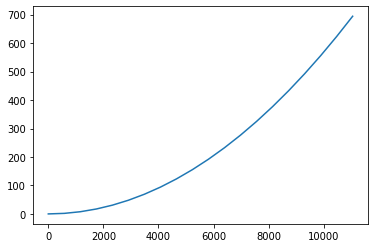

In [116]:
plt.plot(x0, z0)
plt.show()

In [117]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [118]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [119]:
V_rho

array([[6.0751987e+10, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.0751987e+10, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.0751987e+10]])

In [120]:
Jv(x0,[0 for i in range(len(z0))],z0,len(z0))

array([[11343.54497195,     0.        ,   730.0505151 ],
       [10761.82471698,     0.        ,   728.12942422],
       [10180.104462  ,     0.        ,   722.36606778],
       [ 9598.38420703,     0.        ,   712.76019434],
       [ 9016.66395206,     0.        ,   699.31138488],
       [ 8434.94369709,     0.        ,   682.01905269],
       [ 7853.22344212,     0.        ,   660.88244341],
       [ 7271.50318715,     0.        ,   635.90063499],
       [ 6689.78293217,     0.        ,   607.0725376 ],
       [ 6108.0626772 ,     0.        ,   574.39689366],
       [ 5526.34242223,     0.        ,   537.87227772],
       [ 4944.62216726,     0.        ,   497.49709644],
       [ 4362.90191229,     0.        ,   453.26958847],
       [ 3781.18165732,     0.        ,   405.18782444],
       [ 3199.46140234,     0.        ,   353.24970683],
       [ 2617.74114737,     0.        ,   297.45296988],
       [ 2036.0208924 ,     0.        ,   237.79517953],
       [ 1454.30063743,     0. 

In [121]:
def Joma(J):
    return (J/(J.max(axis=0)+1e-6))[::-1]

In [122]:
def Joma_I(I):
    ans=[]
    for i in range(len(I)):
#         print(I[-1].diagonal()[0]/I[i].diagonal()[0])
        ans.append(I[-1].diagonal()/I[i].diagonal())
    return np.array(ans)

In [123]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [124]:
I511=Joma_I(Irho)

In [125]:
def Joma_M(I):
    ans=[]
    for i in range(len(I)):
        ans.append(I[-1]/I[i])
    return np.array(ans)

In [126]:
I511

array([[0.99999997, 0.99999997, 0.99999994],
       [0.99999997, 0.99999997, 0.99999994],
       [0.99999997, 0.99999997, 0.99999994],
       [0.99999997, 0.99999997, 0.99999995],
       [0.99999998, 0.99999998, 0.99999995],
       [0.99999998, 0.99999998, 0.99999995],
       [0.99999998, 0.99999998, 0.99999996],
       [0.99999998, 0.99999998, 0.99999996],
       [0.99999998, 0.99999998, 0.99999996],
       [0.99999998, 0.99999998, 0.99999997],
       [0.99999999, 0.99999999, 0.99999997],
       [0.99999999, 0.99999999, 0.99999997],
       [0.99999999, 0.99999999, 0.99999998],
       [0.99999999, 0.99999999, 0.99999998],
       [0.99999999, 0.99999999, 0.99999998],
       [0.99999999, 0.99999999, 0.99999999],
       [1.        , 1.        , 0.99999999],
       [1.        , 1.        , 0.99999999],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ]])

In [127]:
M511=Joma_M(M_t)

In [128]:
# def mass(M, m, X,Y,Z):
  
#     M1=Jv(X,Y,Z,len(X))**2*M
# #     print(M1.shape)
# #     print((Jv(X,Y,Z,len(X))**2).shape)
#     M2=Jv(X,Y,Z,len(X))**2*m
    
#     return np.sum(M1+M2,axis=1)

In [129]:
# inert(vessel_mass*9.81,mp*9.81, x0).shape

In [130]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987 for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09 for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569 for i in range(node_N)])
#        q0[(j-1)*node_N]=0 
q0[7*node_N-1]= -0.00010522890316932987 # here
q0[9*node_N-1]= 6.952842745988619e-09
q0[11*node_N-1]=0.00010649100253301569 # here

In [131]:
I511.shape

(20, 3)

In [132]:
M511.shape

(20,)

In [133]:
Joma(Jv(x,y,z,len(z))).shape

(20, 3)

In [134]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
    
    Z0= - np.einsum('ijk,i->ij', Re_b(Ret), np.dot(I511, tau_force[:3].reshape(3,1)).squeeze())
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
#     print(M_t)
    
############################################################ 
#     print(Re_b(Ret).shape,M_t.shape)
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('ijk,ik->ij',Re_b(Ret),M_t),Z).T
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

#     sum_0123=0
#     lll=[]
#     for i in range(1,len(z0)):
#         sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
#         lll.append(sum_0123)
        
#     cum_d_inv=[0]
#     sum_=0
#     for i in range(len(lll)-1,-1,-1):
#         sum_+=lll[i]
#         cum_d_inv.append(sum_)
#     cum_d_inv=cum_d_inv[::-1] 
     
    
#     Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    
    C0=-np.einsum('ijk,i->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), np.dot(I511,tau_force[:3].reshape(3,1)).squeeze()) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [135]:
q0

array([ 0.00000000e+00,  5.81720255e+02,  1.16344051e+03,  1.74516076e+03,
        2.32688102e+03,  2.90860127e+03,  3.49032153e+03,  4.07204178e+03,
        4.65376204e+03,  5.23548229e+03,  5.81720255e+03,  6.39892280e+03,
        6.98064306e+03,  7.56236331e+03,  8.14408357e+03,  8.72580382e+03,
        9.30752408e+03,  9.88924433e+03,  1.04709646e+04,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [136]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [137]:
root

array([ 0.00000000e+00,  5.81720255e+02,  1.16344051e+03,  1.74516076e+03,
        2.32688102e+03,  2.90860127e+03,  3.49032153e+03,  4.07204178e+03,
        4.65376204e+03,  5.23548229e+03,  5.81720255e+03,  6.39892280e+03,
        6.98064306e+03,  7.56236331e+03,  8.14408357e+03,  8.72580382e+03,
        9.30752408e+03,  9.88924433e+03,  1.04709646e+04,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [138]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [139]:
q0=root

In [140]:
q0

array([ 0.00000000e+00,  5.81720255e+02,  1.16344051e+03,  1.74516076e+03,
        2.32688102e+03,  2.90860127e+03,  3.49032153e+03,  4.07204178e+03,
        4.65376204e+03,  5.23548229e+03,  5.81720255e+03,  6.39892280e+03,
        6.98064306e+03,  7.56236331e+03,  8.14408357e+03,  8.72580382e+03,
        9.30752408e+03,  9.88924433e+03,  1.04709646e+04,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [141]:
# x0_

In [142]:
# z0

In [143]:
# z0_

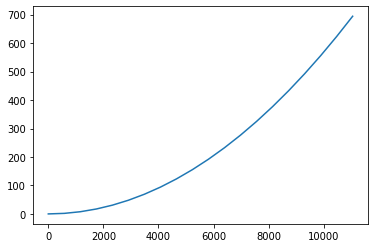

In [144]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [145]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [146]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [147]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [148]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [149]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [150]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [151]:
f

array([-1.00000000e+01, -3.83026943e-15,  2.00000000e+01,  4.20496971e-15,
        2.22044605e-16, -1.20736754e-15,  9.87206850e+00, -3.05675021e-02,
       -1.07838097e-01, -2.02690310e-03, -1.73997236e-01,  2.99464928e-02,
        9.02939690e-02, -3.92960434e-02, -1.98477415e+01,  3.86750341e-02,
        1.23200864e-01, -1.59047604e-03,  3.76375299e-02,  6.98635455e-02,
       -4.44204429e-02, -9.64417725e-02, -1.83601343e-03, -8.72036301e-02])

In [172]:
def PipeForce(X,Y,Z,vessel_force, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(0,(len(X)-1)*6))

    bc_val=[0]*(len(X)-1)*6
    global_force=np.zeros(len(X)*6) 
    global_force[-6:]=vessel_force
    d,f=FEA_u(coord,elcon,bc_node,bc_val,global_force,E,G,A,Iy,Iz,J)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    print(d) 
    return np.array(fors), np.array(mom), np.array(angle)

In [175]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,np.array([67067.8422171882,
                 8866784.826883841, 
                 136429924.3688211, 
                 760945444.8381816, 
                 -5770549859.826721, 
                 374662591.12388337]))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [176]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

In [154]:
.

SyntaxError: invalid syntax (<ipython-input-154-a5d5b61aa8a6>, line 1)

### Vessle Simulation

In [ ]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [ ]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [ ]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [ ]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

In [ ]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [ ]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

In [ ]:
plotVehicleStates(simTime, simData, 3)

In [ ]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [ ]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
# Ws[0]*Ret[2]

In [ ]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [ ]:
idx=1/0.01

In [ ]:
idx

In [ ]:
ssa(simData[:, 3][int(idx)])

In [ ]:
ssa(simData[:, 4][int(idx)])

In [ ]:
ssa(simData[:, 5][int(idx)])

In [ ]:
idx=int(idx)

In [ ]:
x_ve = simData[:, 0][idx]
y_ve = simData[:, 1][idx]
z_ve = simData[:, 2][idx]
phi_ve = ssa(simData[:, 3][idx])
theta_ve = ssa(simData[:, 4][idx])
psi_v = ssa(simData[:, 5][idx])


u_ve = simData[:, 6][idx]
v_ve = simData[:, 7][idx]

w_ve = simData[:, 8][idx]
p_ve = simData[:, 9][idx]
q_ve = simData[:, 10][idx]
r_ve = simData[:, 11][idx]

In [ ]:
η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])

In [ ]:
n_ = myDPcontrol(vehicle,η,dη,sampleTime)

In [ ]:
x,y,z=q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [ ]:
fors, mom, angle = PipeForce(x,y,z,n_)

In [ ]:
angle

### Dynamics

In [ ]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
#     force_schedule=1e-4
    force_schedule=1
#     force_schedule=0
#     print(type(n_))
#     tau_force = force_schedule*np.array(n_) # [N]
    
    fors, mom, angle = force_schedule*PipeForce(x,y,z,n_)
    
    φ,θ,ψ=angle.T
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0
#     print(tau_force.astype(np.float64))

#     sum_0123=0
#     lll=[]
#     for i in range(1,len(z0)):
#         sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
#         lll.append(sum_0123)

    
#     cum_d_inv=[0]
#     sum_=0
#     for i in range(len(lll)-1,-1,-1):
#         sum_+=lll[i]
#         cum_d_inv.append(sum_)
#     cum_d_inv=cum_d_inv[::-1]   

#     print(np.dot(1/(Jv(x,y,z,len(z))+1e-3),tau_force[:3].reshape(3,1)).squeeze())
#     print(tau_force[:3])
#     Z0=-np.einsum('ijk,ik->ij', Re_b(Ret), np.einsum('i,k->ik',cum_d_inv[::-1],tau_force[:3])/max(cum_d_inv))
    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     Z0=-tau_force[:3]
#     print(Ret)
#     print(Z0.shape)
#     print(Z0)
    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (
        Z1
        + Z2 
        +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    haka=1
    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
#     ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
    
    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
# #                                              [Ws[i] for i in range(node_N)]
# #                                              +[Ws[-1] + vessel_mass]
#                                              haka*M_totl
                                          
#                                              ,RRRR),
#                                    Z
#                                   ).T 
# #     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      


#     print(cum_d_inv[0])
#     Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
#                  ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

#     C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
#     A2 = Irho_e(Ret,Irho).astype(np.float64)
#     A3=Π(φ,θ,ψ).astype(np.float64)

#     A=np.einsum('ijk,ikr->ijr',A2,A3)
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111[-1])
    return A1111

In [ ]:
# import scipy

In [ ]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [ ]:
# us=ode15s.integrate(10)

In [ ]:
tspan = (0., 0.12)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

In [ ]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init), force_schedule, hak and haka

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
ax.view_init(0,-70)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()